## Import libraries and the data

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from textblob import Word
import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from nltk.tokenize import RegexpTokenizer
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm
import tensorflow as tf
import sys
from keras import backend as K
import nltk

nltk.download('wordnet')

train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')
test_y = pd.read_csv('data/test_labels.csv')
test_y = test_y.drop('id', axis = 1)

pd.options.display.max_colwidth = 150
plt.style.use('ggplot')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## EDA

In [2]:
train_df.head(20)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I ...",0,0,0,0,0,0
1,000103f0d9cfb60f,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits in...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember what page that's on?",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the tools well. · talk """,0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,"Your vandalism to the Matt Shirvington article has been reverted. Please don't do it again, or you will be banned.",0,0,0,0,0,0
8,00037261f536c51d,"Sorry if the word 'nonsense' was offensive to you. Anyway, I'm not intending to write anything in the article(wow they would jump on me for vandal...",0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contrary to those of DuLithgow,0,0,0,0,0,0


In [3]:
train_df['comment_text'].tail(20)

159551    While about half the references are from BYU-I, the majority comes from the independent student paper Scroll, which probably is the most reliable ...
159552                                                           Prague Spring \n\nI think that Prague Spring deserves more than two sentences in this article.
159553    I see this as having been merged; undoing one side of a merge forks content in large blocks. See here and here where the article was merged. The p...
159554    and i'm going to keep posting the stuff u deleted until this fucking site closes down have fun u stupid ass bitch don't ever delete anything fucki...
159555                                "\n\nHow come when you download that MP3 it's titled ""odb""? That's ODB's theme and that has been my point all along.  "
159556                                                                                                I'll be on IRC, too, if you have a more specific request.
159557    It is my opinion that that hap

<BarContainer object of 2 artists>

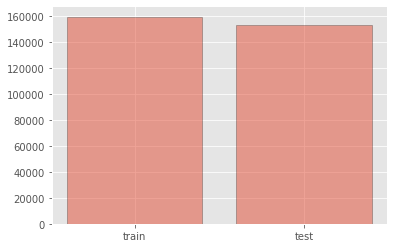

In [4]:
plt.bar(['train', 'test'], [train_df.shape[0], test_df.shape[0]], alpha = 0.5, edgecolor = 'black')

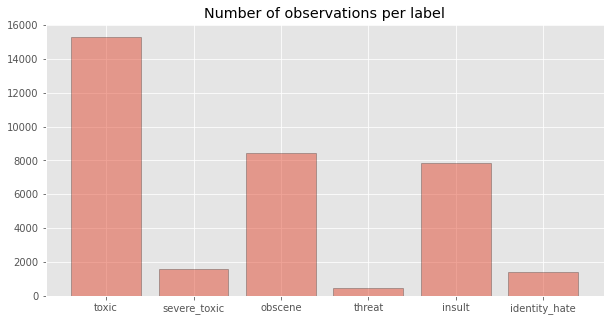

In [5]:
label_columns = train_df.columns[2:]
label_count = []

for column in label_columns:
    label_count.append(train_df[column].sum())

plt.figure(figsize = (10, 5))
plt.bar(label_columns, label_count, alpha = 0.5, edgecolor = 'black')
plt.title('Number of observations per label')
plt.show()

This plot shows the imbalance between labels

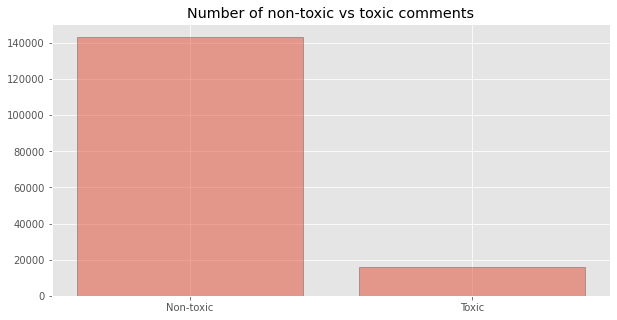

In [6]:
nontoxic_indices = train_df[label_columns].apply(lambda row : True if (row.sum() == 0) else False, 1) # Get non-toxic observations 
nontoxic_comments = train_df[nontoxic_indices == True]
toxic_comments = train_df[nontoxic_indices == False]
nontoxic_no = train_df[nontoxic_indices].shape[0]
toxic_no = train_df.shape[0] - nontoxic_no

plt.figure(figsize = (10, 5))
plt.bar(['Non-toxic', 'Toxic'], [nontoxic_no, toxic_no], alpha = 0.5, edgecolor = 'black')
plt.title('Number of non-toxic vs toxic comments')
plt.show()

Further imbalance between the comments that don't contain any toxicity and those that contain any type

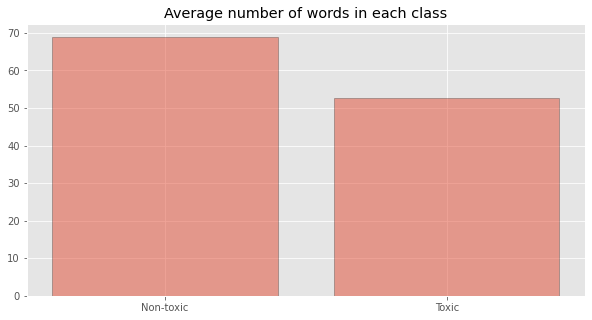

In [7]:
nontoxic_wordcount = nontoxic_comments['comment_text'].apply(lambda text : len([word for word in text.split()]))
nontoxic_avg_wordcount = nontoxic_wordcount.sum() / nontoxic_wordcount.shape[0]

toxic_wordcount = toxic_comments['comment_text'].apply(lambda text : len([word for word in text.split()]))
toxic_avg_wordcount = toxic_wordcount.sum() / toxic_wordcount.shape[0]

plt.figure(figsize = (10, 5))
plt.bar(['Non-toxic', 'Toxic'], [nontoxic_avg_wordcount, toxic_avg_wordcount], alpha = 0.5, edgecolor = 'black')
plt.title('Average number of words in each class')
plt.show()

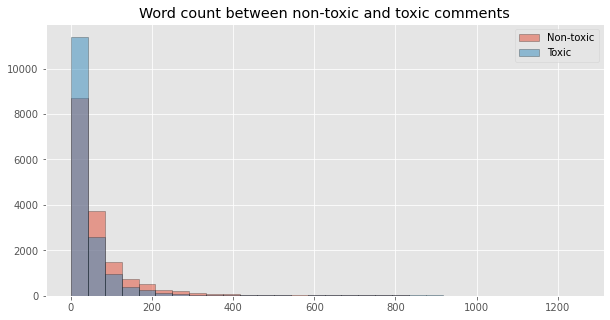

In [8]:
bins_num = 30

# Adjust for the class imbalance by randomly sampling non-toxic word lengths
wordcount_nt = nontoxic_wordcount.sample(n = toxic_wordcount.shape[0])
wordcount_t = toxic_wordcount

plt.figure(figsize = (10, 5))
_, bins, _ = plt.hist(wordcount_nt, bins_num, alpha = 0.5, edgecolor = 'black', label = 'Non-toxic')
plt.hist(wordcount_t, bins, alpha = 0.5, edgecolor = 'black', label = 'Toxic')
plt.title('Word count between non-toxic and toxic comments')
plt.legend()
plt.show()

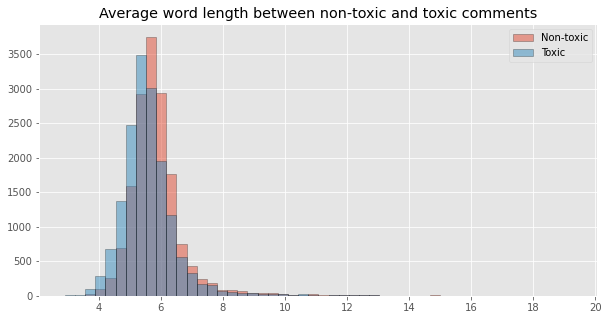

In [9]:
charcount_nt = nontoxic_comments['comment_text'].apply(lambda comment : len(comment))
avg_word_nt = charcount_nt / nontoxic_wordcount
avg_word_nt = avg_word_nt.sample(n = toxic_comments.shape[0])

charcount_t = toxic_comments['comment_text'].apply(lambda comment : len(comment))
avg_word_t = charcount_t / toxic_wordcount

bins_num = 50
plt.figure(figsize = (10, 5))
_, bins, _ = plt.hist(avg_word_nt[avg_word_nt < 20], bins_num, alpha = 0.5, edgecolor = 'black', label = 'Non-toxic')
plt.hist(avg_word_t[avg_word_t < 20], bins, alpha = 0.5, edgecolor = 'black', label = 'Toxic')
plt.title('Average word length between non-toxic and toxic comments')
plt.legend()
plt.show()

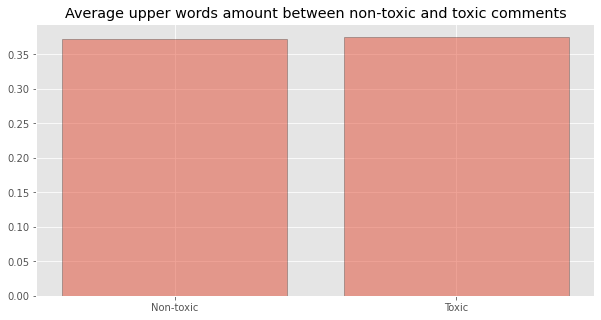

In [10]:
upper_words_nt = nontoxic_comments['comment_text'].apply(lambda comment: len([word for word in comment.split() if word.isupper() and len(word) > 1]))
avg_upper_nt = len(upper_words_nt[upper_words_nt > 0]) / len(upper_words_nt)

upper_words_t = toxic_comments['comment_text'].apply(lambda comment: len([word for word in comment.split() if word.isupper() and len(word) > 1]))
avg_upper_t = len(upper_words_t[upper_words_t > 0]) / len(upper_words_t)

plt.figure(figsize = (10, 5))
plt.bar(['Non-toxic', 'Toxic'], [avg_upper_nt, avg_upper_t], alpha = 0.5, edgecolor = 'black')
plt.title('Average upper words amount between non-toxic and toxic comments')
plt.show()

## Preprocessing

In [11]:
# Preprocessing steps chosen to optimise the predictions
def preprocessing(dataset):
    # Convert tweets to lowercase
    dataset['comment_text'] = dataset['comment_text'].apply(lambda text : " ".join(word.lower() for word in text.split())) 
    
    # Remove punctuation
    dataset['comment_text'] = dataset['comment_text'].str.replace('[^\w\s]', '') 
    
    # Remove non-alphabetic characters
    # Not sure about this one since some people substitute letters with numbers in insults
    # dataset['comment_text'] = dataset['comment_text'].str.replace("[^A-Za-z']+", ' ')

    # Spelling correction.
    # Will most likely try to correct a lot of slang and shorthands for insult words
    #dataset['text'][:10].apply(lambda tweet : str(TextBlob(tweet).correct()))    

    # Lemmatization of the words
    dataset['comment_text'] = dataset['comment_text'].apply(lambda text : " ".join(Word(word).lemmatize() for word in text.split())) 

    # Remove stop words from tweets
    #stop = stopwords.words('english') # Get english stopwords list
    #dataset['text'] = dataset['text'].apply(lambda tweet : " ".join(word for word in tweet.split() if word not in stop)) 

    # Rarest / Most common words
    # freq = pd.Series(' '.join(dataset['text']).split()).value_counts()[-50:]
    
    return dataset

In [13]:
train_df = preprocessing(train_df)

tokenizer = RegexpTokenizer(r'\w+')
train_tokenized = [tokenizer.tokenize(word) for word in train_df['comment_text']] 

## Embedding using Word2Vec

In [14]:
model_path = 'word2vec model/toxic_comments_word2vec.model'
vector_size = 300

if not os.path.exists(model_path):
    # Fine tuning pre-trained model
    vector_model = Word2Vec(size = vector_size, min_count = 1)
    vector_model.build_vocab(train_tokenized)
    total_examples = vector_model.corpus_count

    vector_model.intersect_word2vec_format('word2vec model/GoogleNews-vectors-negative300.bin', binary = True, lockf = 1.0)
    vector_model.train(train_tokenized, total_examples = total_examples, epochs = 5)
    
    # Save the model
    vector_model.save(model_path)
else:
    vector_model = Word2Vec.load(model_path)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [15]:
def create_feature_vector(comments, model, vector_size):
    model_word_set = set(model.wv.index2word)
    
    comment_feature_vector = np.zeros((len(comments), vector_size), dtype='float32')
    i = 0
    
    for comment in tqdm(comments):
        feature_vector = np.zeros((vector_size,), dtype="float32")
        feature_number = 0
        for word in comment:
            if word in model_word_set:
                feature_number += 1
                feature_vector = np.add(feature_vector, model.wv[word])
        comment_feature_vector[i] = np.divide(feature_vector, feature_number)
        i += 1
                
    return comment_feature_vector

## Random Forest Model

In [16]:
# Create sentence vectors for train data
# train_data_vectors = create_feature_vector(train_df['comment_text'], vector_model, vector_size)

In [17]:
# Train Random Forest classifier
# random_forest_model = RandomForestClassifier(n_estimators = 100, verbose = 1, n_jobs = -1)
# random_forest_model = random_forest_model.fit(train_data_vectors, train_df.iloc[:, 2:])

In [18]:
# Create sentence vectors for test data
# test_data_vectors = create_feature_vector(test_df['comment_text'], vector_model, vector_size)

In [19]:
# Remove NaN / infinity values to 0
# test_data_vectors = np.nan_to_num(test_data_vectors)

# Get predictions
# predictions = random_forest_model.predict(test_data_vectors)

## Neural Network

In [20]:
# Define f1 metric function
def f1_m(precision, recall):
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

In [21]:
# Create sentence vectors for train data
train_data_vectors = create_feature_vector(train_df['comment_text'], vector_model, vector_size)

100%|██████████| 159571/159571 [02:00<00:00, 1319.22it/s]


In [22]:
# Create the model
nn_model = tf.keras.models.Sequential()
nn_model.add(tf.keras.layers.Dense(vector_size, activation = tf.nn.relu))
nn_model.add(tf.keras.layers.Dense(vector_size, activation = tf.nn.relu))
nn_model.add(tf.keras.layers.Dense(6, activation = tf.nn.sigmoid))

nn_model.compile(loss="binary_crossentropy", optimizer='adam',
	metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

# Train
nn_model.fit(train_data_vectors, train_df.iloc[:, 2:], epochs = 3)

Epoch 1/3
4987/4987 [==============================] - 19s 4ms/step - loss: 0.1147 - accuracy: 0.9818 - precision: 0.6804 - recall: 0.1353
Epoch 2/3
4987/4987 [==============================] - 19s 4ms/step - loss: 0.1100 - accuracy: 0.9930 - precision: 0.7143 - recall: 0.1637
Epoch 3/3
4987/4987 [==============================] - 16s 3ms/step - loss: 0.1082 - accuracy: 0.9927 - precision: 0.7171 - recall: 0.1723


In [23]:
# Create sentence vectors for test data
test_data_vectors = create_feature_vector(test_df['comment_text'], vector_model, vector_size)

  0%|          | 0/153164 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
100%|██████████| 153164/153164 [01:40<00:00, 1521.94it/s]


In [24]:
# Remove NaN / infinity values to 0
test_data_vectors = np.nan_to_num(test_data_vectors)

predictions = nn_model.predict(test_data_vectors)

# Round the predictions
threshold = .5
predictions[predictions >= threshold] = -1
predictions[predictions < threshold] = 0

In [25]:
# Get the evaluation metrics
val_loss, val_acc, val_prec, val_rec = nn_model.evaluate(test_data_vectors, test_y)
val_f1 = f1_m(val_prec, val_rec)

4787/4787 [==============================] - 7s 1ms/step - loss: -2.4603 - accuracy: 0.9979 - precision: 0.8817 - recall: 0.0193


In [26]:
print('Loss: ' + str(val_loss))
print('Acc: ' + str(val_acc))
print('F1: ' + str(val_f1))
print('Precision: ' + str(val_prec))
print('Recall: ' + str(val_rec))

Loss: -2.4603078365325928
Acc: 0.9979498982429504
F1: 0.03775734562763345
Precision: 0.8817463517189026
Recall: 0.019291721284389496


## Submission

In [27]:
def submission(ids, predictions):
    print(len(predictions))
    predictions_df = pd.DataFrame(predictions, columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'])
    submission_data = pd.concat([ids, predictions_df], axis = 1)
    submission_data.to_csv("submission.csv", index=False)

In [28]:
submission(test_df['id'], predictions)

153164
